# License Plates Recognition

Ivan Martín Campoy (NIU), Aina Navarro Ràfols (1670797), Sara Martín Núñez (1669812)

# _Part I: ANPR Location_

In [253]:
import os
from os import listdir
import cv2
from matplotlib import pyplot as plt
import numpy as np
from skimage.transform import resize
import imutils

## Pipeline to extract plate from example image

In [254]:
image_path = "Test/Test/Lateral/Lateral/6401JBX.jpg"
image = cv2.imread(image_path)
image = imutils.resize(image, width=640)

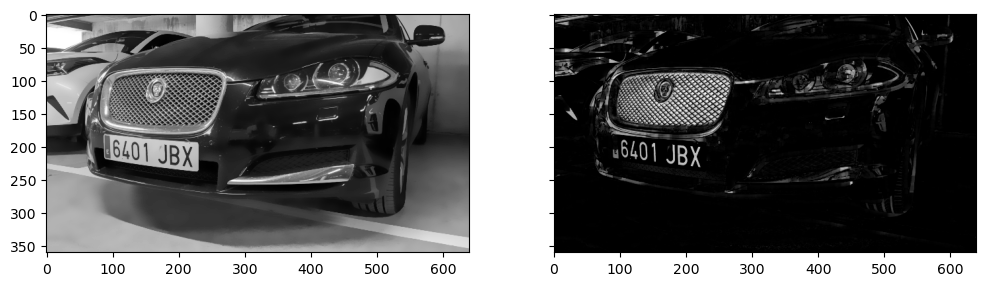

In [255]:
# To grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Bilateral filter to smooth
bilat = cv2.bilateralFilter(gray,15,17,17)
# Blackhat
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
blackhat = cv2.morphologyEx(bilat, cv2.MORPH_BLACKHAT, kernel, iterations=3)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 6))
ax1.imshow(bilat, cmap= 'gray')
ax2.imshow(blackhat, cmap= 'gray')

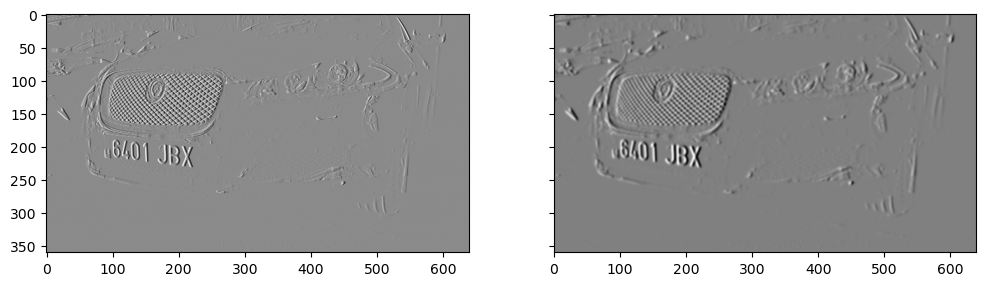

In [256]:
# Sobelx: detect borders
sobelx = cv2.Sobel(blackhat,cv2.CV_64F,dx=1, dy=0, ksize=1)
# Gaussian blur: Smooth noise and delete borders we don't need
smooth = cv2.GaussianBlur(sobelx, (7,7),0)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 6))
ax1.imshow(sobelx, cmap= 'gray')
ax2.imshow(smooth, cmap= 'gray')

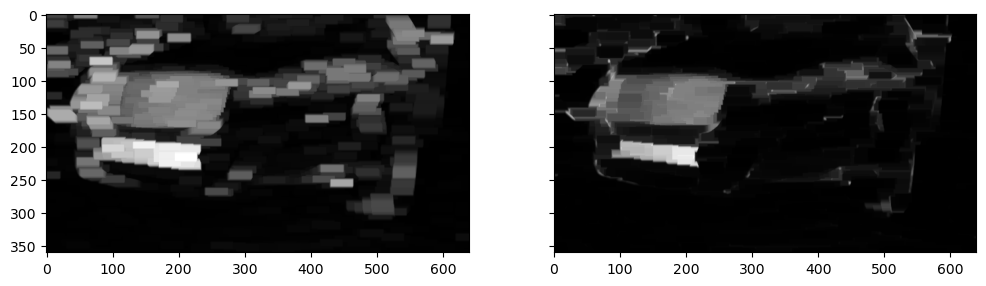

In [257]:
# Closing (but separated to see evolution - closing = dilation then erosion)

filter_size = (17,5)
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, filter_size)

# Dilation
dilation = cv2.dilate(smooth, rect_kernel, iterations=2)

# Erode
erosion = cv2.erode(dilation, rect_kernel, iterations=2)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 6))
ax1.imshow(dilation, cmap= 'gray')
ax2.imshow(erosion, cmap= 'gray')

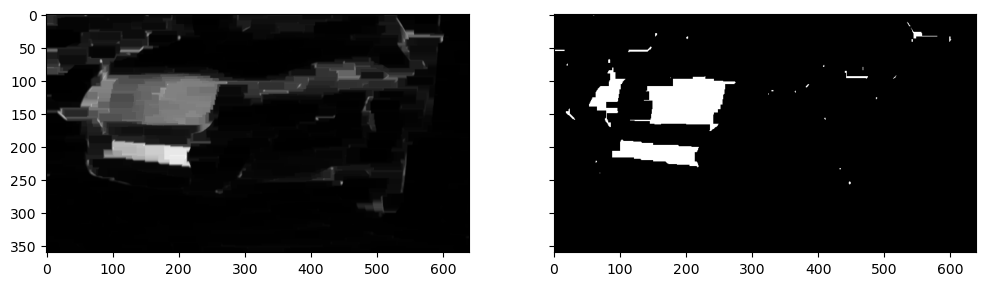

In [258]:
# Threshold
threshold_value = (0.40)*np.max(erosion)
_, bin_threshold = cv2.threshold(erosion, threshold_value, 255, cv2.THRESH_BINARY)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 6))
ax1.imshow(erosion, cmap= 'gray')
ax2.imshow(bin_threshold, cmap= 'gray')

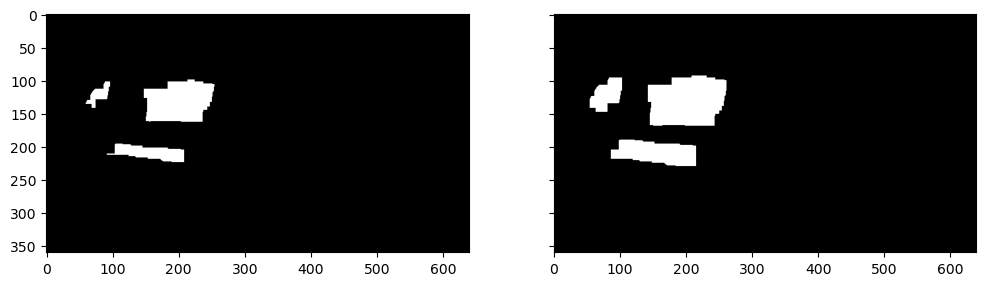

In [259]:
# Erosion and dilation again
erosion2 = cv2.erode(bin_threshold,kernel,iterations=4)
dilation2 = cv2.dilate(erosion2,kernel,iterations=6)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 6))
ax1.imshow(erosion2, cmap= 'gray')
ax2.imshow(dilation2, cmap= 'gray')


In [260]:
def delete_borders(image):
    """
    Function to delete borders by iterating white pixels 
    touching borders and doing Floodfill
    """
    out_image = image.copy()
    h, w = image.shape[:2]
    for row in range(h):
        if out_image[row, 0] == 255:
            cv2.floodFill(out_image, None, (0, row), 0)
        if out_image[row, w - 1] == 255:
            cv2.floodFill(out_image, None, (w - 1, row), 0)
    for col in range(w):
        if out_image[0, col] == 255:
            cv2.floodFill(out_image, None, (col, 0), 0)
        if out_image[h - 1, col] == 255:
            cv2.floodFill(out_image, None, (col, h - 1), 0)
    return out_image

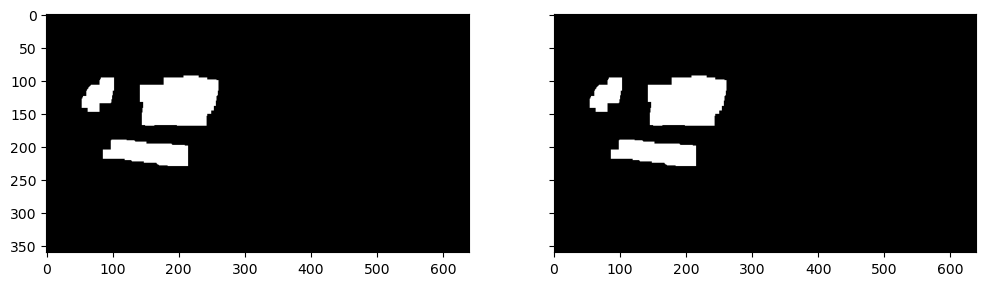

In [261]:
# Avoid erros because of type of image
processed_image = dilation2.astype(np.uint8)
# Delete borders
no_borders = delete_borders(processed_image)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 6))
ax1.imshow(processed_image, cmap= 'gray')
ax2.imshow(no_borders, cmap= 'gray')

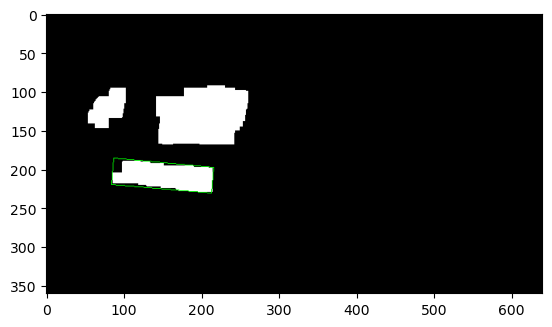

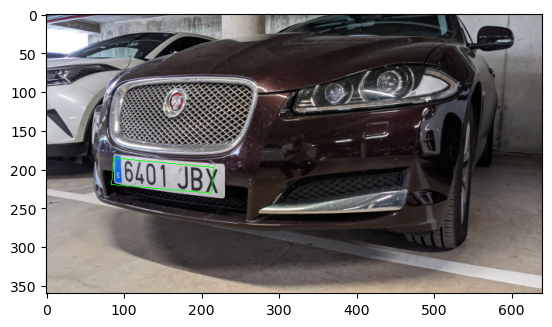

In [262]:
# Obtain largest contour
contours, _ = cv2.findContours(no_borders, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #find image countours

# Order contours in descending order
contours = sorted(contours, key=cv2.contourArea, reverse=True)

selected_contour = None

# Choose largest contour with ratio 11:52 (with margin error)
for cont in contours:
    x, y, w, h = cv2.boundingRect(cont)
    ratio = h/w
    if 0.15 <= ratio <= 0.35:
        selected_contour = cont
        break

if not isinstance(selected_contour, np.ndarray):
    selected_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(selected_contour)

# Get minimum area rectangle to enclose the contour
rectangle = cv2.minAreaRect(selected_contour)

# Get 4 corners points of rectangle
box = cv2.boxPoints(rectangle)
box = np.intp(box) #convert to integer

# Draw rectangle
output_image = cv2.cvtColor(no_borders, cv2.COLOR_GRAY2BGR)  #convert to BGR for color display
cv2.polylines(output_image, [box], isClosed=True, color=(0,255,0), thickness=1)

# Display the results
plt.imshow(output_image)
plt.show()

# Draw rectangle on original image
im_copy = image.copy() #create a copy so the original image doesnt get affected
cv2.polylines(im_copy, [box], isClosed=True, color=(0,255,0), thickness=1)

# Show the result
plt.imshow(cv2.cvtColor(im_copy, cv2.COLOR_BGR2RGB))  #convert BGR to RGB for display purposes
plt.show()

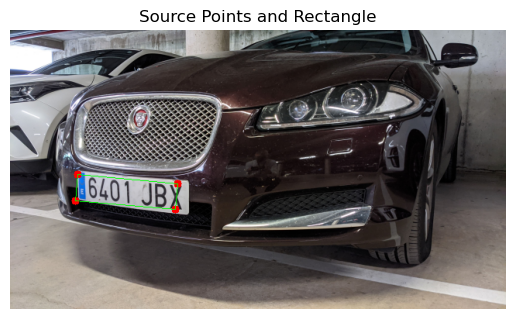

In [263]:
# Dimensions of the rectangle
w = int(rectangle[1][0])  # Width of the detected rectangle
h = int(rectangle[1][1])  # Height of the detected rectangle

# Define margins
margin = 1
top_margin = int(0.02 * h)  # 5% margin at the top
right_margin = int(0.1 * w)  # Increased margin on the right (20% of width)

# Get the original rectangle points
source_points = np.array(box, dtype="float32")

# Draw the source points on a copy of the image
image_with_points = image.copy()

# Draw circles at each source point
for point in source_points:
    cv2.circle(image_with_points, (int(point[0]), int(point[1])), 5, (0, 0, 255), -1)  # Red circles

# Draw lines connecting the source points to visualize the rectangle
cv2.polylines(image_with_points, [np.int32(source_points)], isClosed=True, color=(0, 255, 0), thickness=1)  # Green lines

# Display the image with source points
plt.imshow(cv2.cvtColor(image_with_points, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.axis('off')  # Turn off axis
plt.title("Source Points and Rectangle")  # Title for clarity
plt.show()

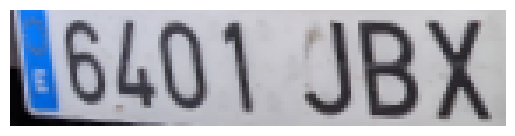

In [264]:
# Get a copy of the original image
im_copy = image.copy()

# Check the orientation
if h > w:
    # Define destination points for portrait-oriented plates
    destination_points = np.array([
        [0 + margin, h - 1 + top_margin - margin],   # Bottom-left
        [0 + margin, 0 + top_margin + margin],       # Top-left
        [w - 1, 0 + top_margin + margin],             # Top-right (no margin)
        [w - 1, h - 1 + top_margin - margin]          # Bottom-right (no margin)
    ], dtype="float32")

    # Perspective transform
    perspective_transform = cv2.getPerspectiveTransform(source_points, destination_points)

    # Apply the perspective transformation, increasing the height to accommodate the top margin
    final_image = cv2.warpPerspective(im_copy, perspective_transform, (w, h + top_margin))

    # Rotate the image
    final_image = imutils.rotate_bound(final_image, 90)

else:
    # Define destination points for landscape-oriented plates
    destination_points = np.array([
        [0 + margin, h - 1 - margin],                           # Bottom-left (unchanged)
        [0 + margin, 0 + margin],                               # Top-left (unchanged)
        [w - 1, 0 + margin],                    # Top-right (with right margin)
        [w - 1, h - 1 - margin]                 # Bottom-right (with right margin)
    ], dtype="float32")

    # Perspective transform
    perspective_transform = cv2.getPerspectiveTransform(source_points, destination_points)

    # Apply the perspective transformation, increasing the width to accommodate the right margin
    final_image = cv2.warpPerspective(im_copy, perspective_transform, (w + right_margin, h))

# Show the plate
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis
plt.show()

## Extract all plates and store them in a folder

In [265]:
def extract_plate(image):

    #PREPROCESS IMAGE

    # Resize image
    image = imutils.resize(image, width=640)
    # To grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Bilateral filter to smooth
    bilat = cv2.bilateralFilter(gray,15,17,17)
    # Blackhat
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    blackhat = cv2.morphologyEx(bilat, cv2.MORPH_BLACKHAT, kernel, iterations=3)
    # Sobelx: detect borders
    sobelx = cv2.Sobel(blackhat,cv2.CV_64F,dx=1, dy=0, ksize=1)
    # Gaussian blur: Smooth noise and delete borders we don't need
    smooth = cv2.GaussianBlur(sobelx, (7,7),0)
    # Dilation
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17,5))
    dilation = cv2.dilate(smooth, rect_kernel, iterations=2)
    # Erosion
    erosion = cv2.erode(dilation, rect_kernel, iterations=2)
    # Threshold
    threshold_value = (0.40)*np.max(erosion)
    _, bin_threshold = cv2.threshold(erosion, threshold_value, 255, cv2.THRESH_BINARY)
    # Erosion and dilation again
    erosion2 = cv2.erode(bin_threshold,kernel,iterations=4)
    dilation2 = cv2.dilate(erosion2,kernel,iterations=6)
    # Avoid erros because of type of image
    processed_image = dilation2.astype(np.uint8)
    # Delete borders
    no_borders = delete_borders(processed_image)

    #EXTRACT LARGEST CONTOUR

    # Obtain contours
    contours, _ = cv2.findContours(no_borders, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #find image countours
    
    # Order contours in descending order
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    selected_contour = None

    # Choose largest contour with ratio 11:52 (with margin error)
    for cont in contours:
        x, y, w, h = cv2.boundingRect(cont)
        ratio = h/w
        if 0.15 <= ratio <= 0.35:
            selected_contour = cont
            break
    
    if not isinstance(selected_contour, np.ndarray):
        selected_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(selected_contour)

    # Get minimum area rectangle to enclose the contour
    rectangle = cv2.minAreaRect(selected_contour)
    
    # Get 4 corners points of rectangle
    box = cv2.boxPoints(rectangle)
    box = np.intp(box) #convert to integer
    
    # Dimensions of the rectangle
    w = int(rectangle[1][0])  # Width of the detected rectangle
    h = int(rectangle[1][1])  # Height of the detected rectangle

    # Define margins
    margin = 1
    top_margin = int(0.02 * h)  # 5% margin at the top
    right_margin = int(0.1 * w)  # Increased margin on the right (20% of width)

    # Get the original rectangle points
    source_points = np.array(box, dtype="float32")

    # Get a copy of the original image
    im_copy = image.copy()

    # Check the orientation
    if h > w:
        # Define destination points for portrait-oriented plates
        destination_points = np.array([
            [0 + margin, h - 1 + top_margin - margin],   # Bottom-left
            [0 + margin, 0 + top_margin + margin],       # Top-left
            [w - 1, 0 + top_margin + margin],             # Top-right
            [w - 1, h - 1 + top_margin - margin]          # Bottom-right
        ], dtype="float32")

        # Perspective transform
        perspective_transform = cv2.getPerspectiveTransform(source_points, destination_points)

        # Apply the perspective transformation, increasing the height to accommodate the top margin
        final_image = cv2.warpPerspective(im_copy, perspective_transform, (w, h + top_margin))
        
        # Rotate the image
        final_image = imutils.rotate_bound(final_image, 90)

    else:
        # Define destination points for landscape-oriented plates
        destination_points = np.array([
            [0 + margin, h - 1 - margin],           # Bottom-left
            [0 + margin, 0 + margin],               # Top-left
            [w - 1, 0 + margin],                    # Top-right
            [w - 1, h - 1 - margin]                 # Bottom-right
        ], dtype="float32")

        # Perspective transform
        perspective_transform = cv2.getPerspectiveTransform(source_points, destination_points)

        # Apply the perspective transformation, increasing the width to accommodate the right margin
        final_image = cv2.warpPerspective(im_copy, perspective_transform, (w + right_margin, h))

    # Show the plate
    plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    
    return final_image


Test:

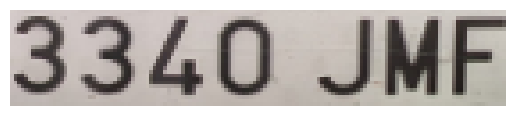

In [266]:
image_path = "Test/Test/Frontal/Frontal/3340JMF.jpg"
image = cv2.imread(image_path)
final_image = extract_plate(image)

All images:

In [267]:
frontal_plates_path = "Test/Test/Frontal/Frontal/"
lateral_plates_path = "Test/Test/Lateral/Lateral/"

In [268]:
# Create folders if they don't exist

# Path of the base folder
base_folder = "PlateImages"

# Subfolders to create inside the base folder
subfolders = ["Frontal", "Lateral"]

# Create the base folder if it doesn't exist
if not os.path.exists(base_folder):
    os.makedirs(base_folder)

# Create the subfolders
for subfolder in subfolders:
    # Generate the full path of each subfolder
    subfolder_path = os.path.join(base_folder, subfolder)
    
    # Create the subfolder if it doesn't exist
    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)

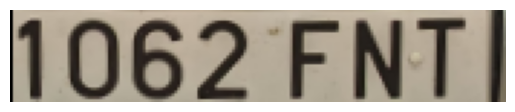

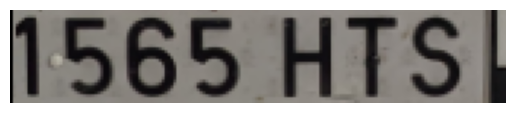

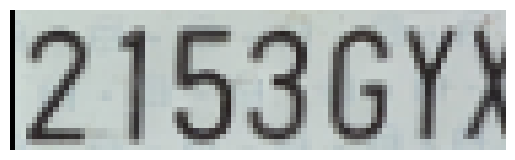

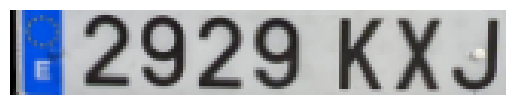

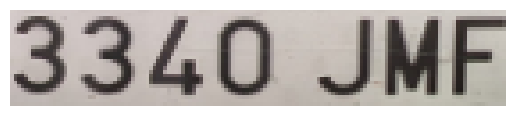

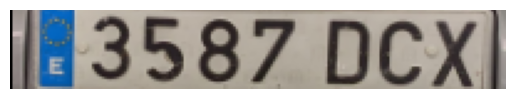

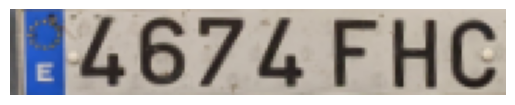

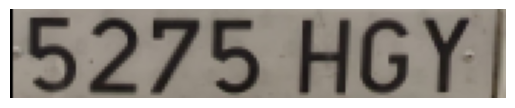

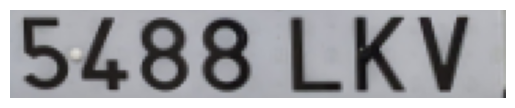

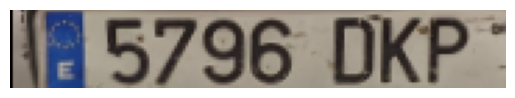

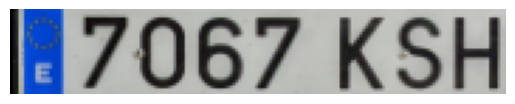

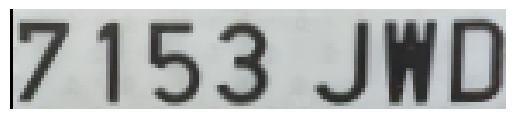

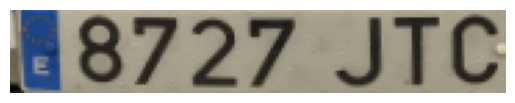

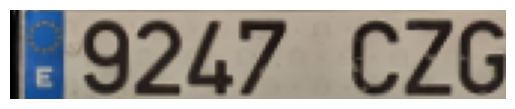

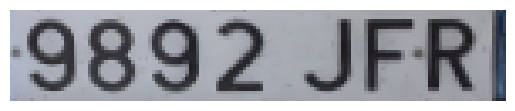

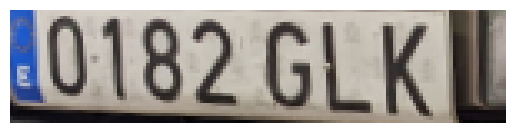

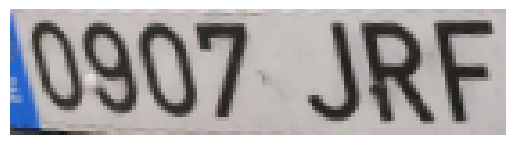

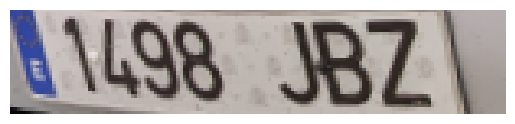

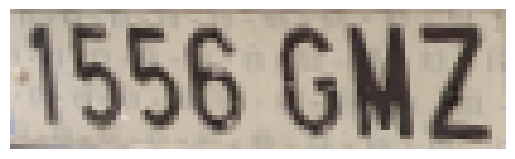

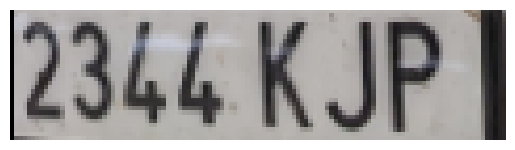

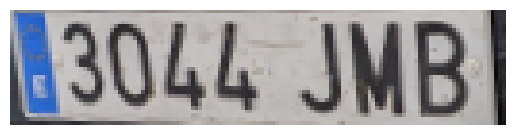

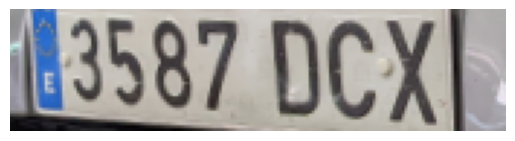

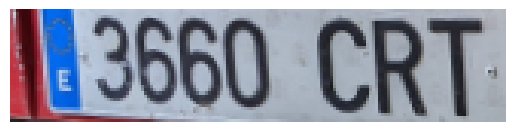

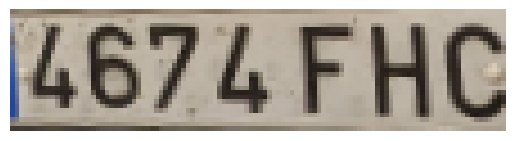

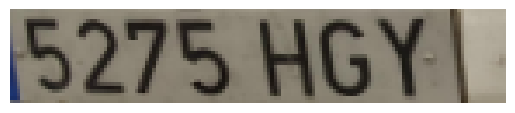

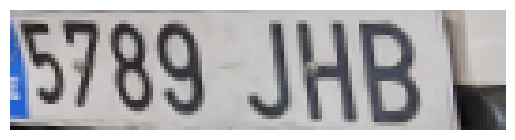

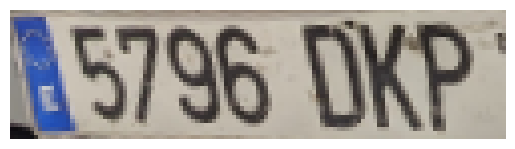

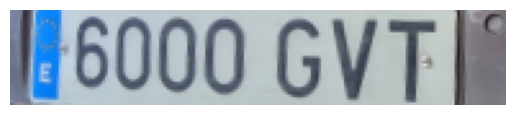

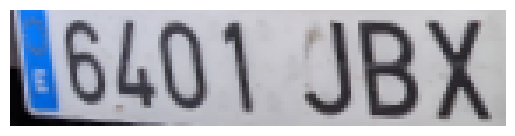

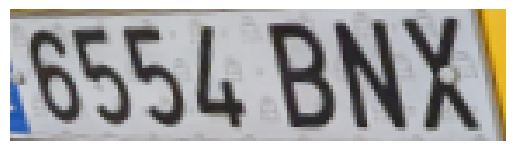

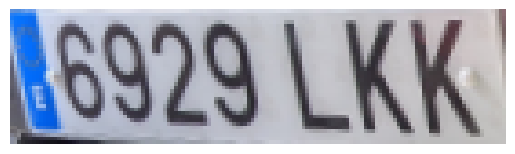

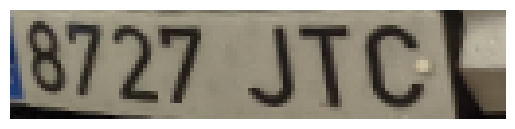

In [269]:
# Frontal plates
for image_path in os.listdir(frontal_plates_path):
    if (image_path.endswith(".png") or image_path.endswith(".jpg") or image_path.endswith(".jpeg")):
        # Get image
        image = cv2.imread(frontal_plates_path+image_path)
        # Extract plate from image
        output_image = extract_plate(image)
        # Create output image name
        output_image_name = "plate_"+image_path
        output_image_path = os.path.join("PlateImages/Frontal", output_image_name)
        # Store final plate image in folder
        cv2.imwrite(output_image_path, output_image)

# Lateral plates
for image_path in os.listdir(lateral_plates_path):
    if (image_path.endswith(".png") or image_path.endswith(".jpg") or image_path.endswith(".jpeg")):
        # Get image
        image = cv2.imread(lateral_plates_path+image_path)
        # Extract plate from image
        output_image = extract_plate(image)
        # Create output image name
        output_image_name = "plate_"+image_path
        output_image_path = os.path.join("PlateImages/Lateral", output_image_name)
        # Store final plate image in folder
        cv2.imwrite(output_image_path, output_image)